In [1]:
from google.colab import drive
isMount=!df |grep /content/drive
if len(isMount)<1: drive.mount('/content/drive')


# CNN Example From Flowers by Keras (Color Version)


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import datasets, layers, models, regularizers

from os import listdir,getcwd
from os.path import isfile, join
import random
import warnings

import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

IMG_W=150
IMG_H=150

In [3]:
def getFolder(thePath,isFile=True):
    return [f for f in listdir(thePath) if isFile == isfile(join(thePath, f)) ]


def getImagesAndLabels(tPath):
    labels=getFolder(tPath,False)

    
    tImages,tLabels=None,None

    for label in labels:
        imgFolder=join(tPath,label)
        files= [f for f in listdir(imgFolder) if isfile(join(imgFolder, f))]
        for file in files:
            imageFile=join(imgFolder,file)
            img=plt.imread(imageFile)
            img = cv2.resize(img, (IMG_W,IMG_H))
            if tImages is None:
                tImages, tLabels =[img], [label]
            else:
                tImages.append( img )
                tLabels.append(label)
        print("finish=",label,"total=",len(tImages))
    return (tImages,tLabels,len(labels))

In [4]:
# ![ ! -f /content/drive/MyDrive/Lec_Capture/_data/flower_photos.tgz  ]&&wget http://download.tensorflow.org/example_images/flower_photos.tgz -O /content/drive/MyDrive/Lec_Capture/_data/flower_photos.tgz 
# !tar xzf /content/drive/MyDrive/Lec_Capture/_data/flower_photos.tgz 
data_path="/content/drive/MyDrive/Lec_Capture/_data/"
url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
filename = join(data_path, "flower_photos.tgz")
get_file(filename, url,extract=True)




'/content/drive/MyDrive/Lec_Capture/_data/flower_photos.tgz'

In [5]:
%%bash
tar xzf /content/drive/MyDrive/Lec_Capture/_data/flower_photos.tgz 
find ./flower_photos|grep jpg|head -n 10|xargs -i -t identify {} 2>>/tmp/log


./flower_photos/roses/2788276815_8f730bd942.jpg JPEG 500x357 500x357+0+0 8-bit sRGB 119KB 0.000u 0:00.000
./flower_photos/roses/4998708839_c53ee536a8_n.jpg JPEG 320x240 320x240+0+0 8-bit sRGB 33.4KB 0.000u 0:00.000
./flower_photos/roses/4363734507_5cc4ed6e01.jpg JPEG 500x434 500x434+0+0 8-bit sRGB 105KB 0.000u 0:00.000
./flower_photos/roses/9702378513_229a96b754_m.jpg JPEG 240x240 240x240+0+0 8-bit sRGB 22.9KB 0.000u 0:00.000
./flower_photos/roses/3422228549_f147d6e642.jpg JPEG 500x329 500x329+0+0 8-bit sRGB 193KB 0.000u 0:00.000
./flower_photos/roses/7683456068_02644b8382_m.jpg JPEG 180x240 180x240+0+0 8-bit sRGB 14.8KB 0.000u 0:00.000
./flower_photos/roses/2677417735_a697052d2d_n.jpg JPEG 320x240 320x240+0+0 8-bit sRGB 29.9KB 0.000u 0:00.000
./flower_photos/roses/505517255_cfbb6f6394.jpg JPEG 500x331 500x331+0+0 8-bit sRGB 99.1KB 0.000u 0:00.000
./flower_photos/roses/2414954629_3708a1a04d.jpg JPEG 500x334 500x334+0+0 8-bit sRGB 73.7KB 0.000u 0:00.000
./flower_photos/roses/9164900485_

In [6]:
from sklearn.model_selection import train_test_split
basePath='./flower_photos'
imgs,labels,class_cnt=getImagesAndLabels(basePath)


finish= roses total= 641
finish= dandelion total= 1539
finish= daisy total= 2172
finish= tulips total= 2971
finish= sunflowers total= 3670


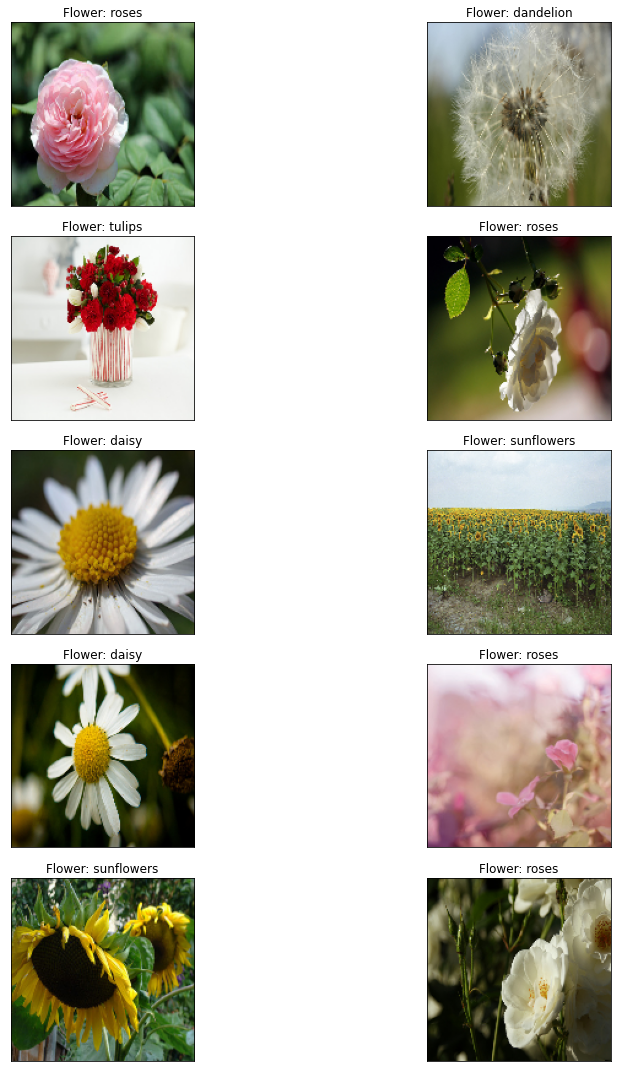

In [7]:
count=0
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range (5):
    for j in range (2):
        l=random.randint(0,len(imgs))
        ax[i,j].imshow(imgs[l])
        ax[i,j].set_title('Flower: '+ labels[l])
        ax[i,j].grid(False)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        count+=1
plt.tight_layout()


In [8]:
le=LabelEncoder()
labels=np.array(labels)

Y=le.fit_transform(labels)
Y=to_categorical(Y,class_cnt)
imgs=np.array(imgs)
imgs=imgs/255.
imgShape=imgs[0].shape

In [9]:
train_images,test_images,train_labels,test_labels=train_test_split(imgs,Y,test_size=0.25, random_state=99)

In [10]:
np.random.seed(42)
random.seed(42)
tf.compat.v1.set_random_seed(42)


from tensorflow.python.keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_images)

In [11]:
model = models.Sequential()
model.add(layers.Conv2D(96, (13, 13), activation='relu', padding='same', input_shape=imgShape))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((3, 3)))


model.add(layers.Conv2D(64, (7, 7), activation='relu', padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((3, 3)))

model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Flatten())

model.add(layers.Dense(200, activation='tanh',kernel_regularizer='l1'))
model.add(layers.Dense(class_cnt, activation='softmax'))
# model.summary()



In [12]:


model.compile(optimizer=Adam(lr=0.001),\
              loss='categorical_crossentropy',metrics=['accuracy'])

batch_size=80
epochs=40
History = model.fit_generator(datagen.flow(train_images,train_labels, batch_size=batch_size),
                      epochs = epochs, 
                      validation_data = (test_images,test_labels), 
                      steps_per_epoch=train_images.shape[0] // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
34/34 [==============================] - 14s 404ms/step - loss: 9.5718 - accuracy: 0.3769 - val_loss: 8.4038 - val_accuracy: 0.3584
Epoch 2/40
34/34 [==============================] - 14s 402ms/step - loss: 6.7944 - accuracy: 0.4742 - val_loss: 5.6393 - val_accuracy: 0.4695
Epoch 3/40
34/34 [==============================] - 14s 400ms/step - loss: 4.7844 - accuracy: 0.5030 - val_loss: 4.1278 - val_accuracy: 0.4336
Epoch 4/40
34/34 [==============================] - 14s 400ms/step - loss: 3.3299 - accuracy: 0.5520 - val_loss: 2.8669 - val_accuracy: 0.5098
Epoch 5/40
34/34 [==============================] - 14s 398ms/step - loss: 2.3664 - accuracy: 0.5805 - val_loss: 2.1371 - val_accuracy: 0.5501
Epoch 6/40
34/34 [==============================] - 13s 396ms/step - loss: 1.8304 - accuracy: 0.5988 - val_loss: 1.8704 - val_accuracy: 0.5098
Epoch 7/40
34/34 [==============================] - 14s 403ms/step

In [13]:
score = model.evaluate_generator(datagen.flow(test_images,test_labels, batch_size=batch_size))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test loss: 0.8743165135383606
Test accuracy: 0.6960784196853638


In [14]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8264800310134888
Test accuracy: 0.7058823704719543


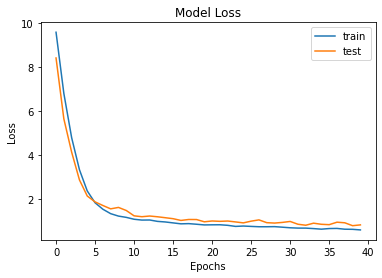

In [15]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


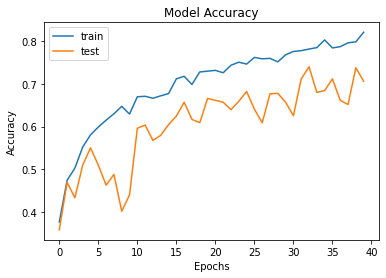

In [16]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [17]:
# getting predictions on val set.
pred=model.predict(test_images)
pred_digits=np.argmax(pred,axis=1)

In [18]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

print('Pred True')
for i in range(len(test_labels)):
    if(np.argmax(test_labels[i])==pred_digits[i]):
      print(np.argmax(test_labels[i]),pred_digits[i])        
      prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
print('Pred False')
for i in range(len(test_labels)):
    if(not np.argmax(test_labels[i])==pred_digits[i]):
      print(np.argmax(test_labels[i]),pred_digits[i])        
      mis_class.append(i)
    if(len(mis_class)==8):
        break

Pred True
1 1
4 4
3 3
2 2
1 1
1 1
3 3
4 4
Pred False
2 4
0 2
2 1
4 2
3 2
4 2
4 1
0 1


--------------------------------------
 True 
--------------------------------------


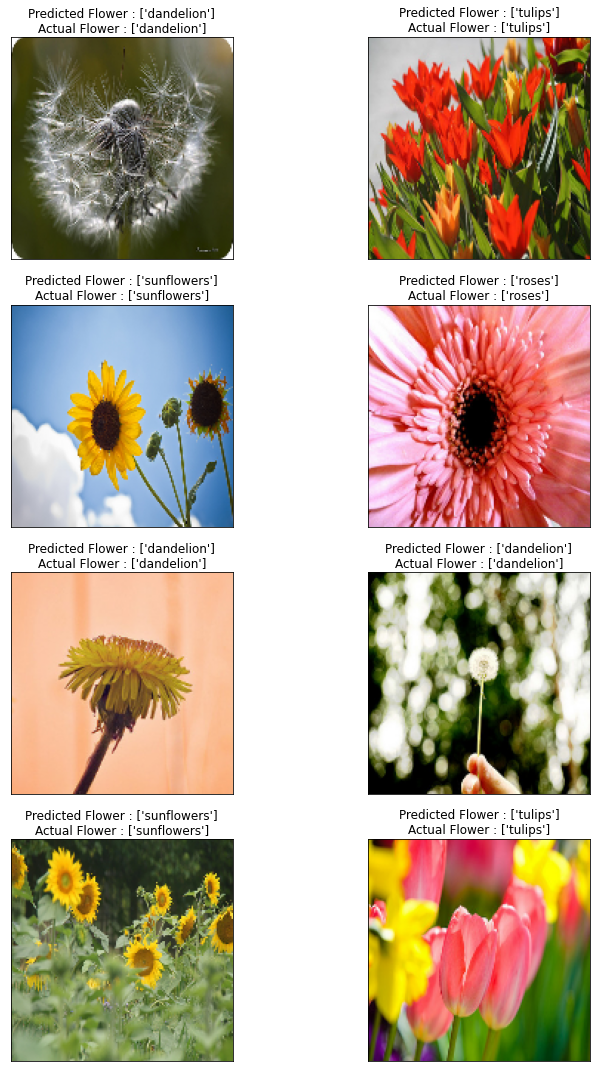

In [19]:

if len(prop_class)<8:
  print("True Prediction is lower then 8")
else:

  print('--------------------------------------')
  print(' True ')
  print('--------------------------------------')
  warnings.filterwarnings('always')
  warnings.filterwarnings('ignore')

  count=0
  fig,ax=plt.subplots(4,2)
  fig.set_size_inches(15,15)
  for i in range (4):
      for j in range (2):
          img=test_images[prop_class[count]]
          ax[i,j].imshow(img)
          ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits     [prop_class[count      ]]]))+"\n"+ \
                            "Actual Flower : "   +str(le.inverse_transform([np.argmax(test_labels[prop_class[count      ]])]))    \
                          )
          ax[i,j].set_xticks([])
          ax[i,j].set_yticks([])

          plt.tight_layout()
          count+=1

--------------------------------------
 mis class
--------------------------------------


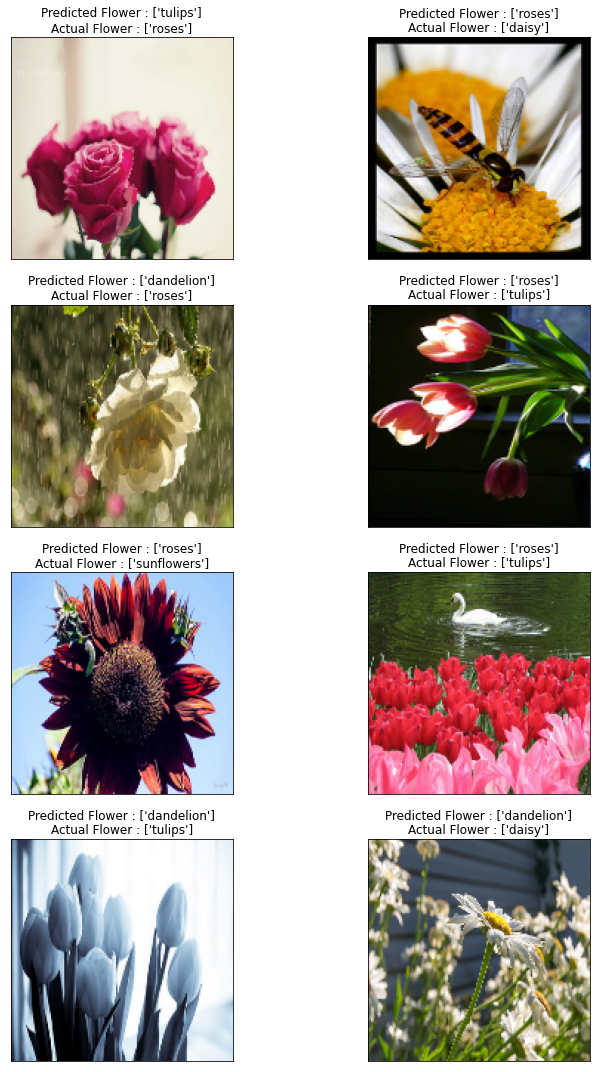

In [20]:
if len(mis_class)<8:
  print("mis_class is lower then 8")
else:
  print('--------------------------------------')
  print(' mis class')
  print('--------------------------------------')
  warnings.filterwarnings('always')
  warnings.filterwarnings('ignore')

  count=0
  fig,ax=plt.subplots(4,2)
  fig.set_size_inches(15,15)
  for i in range (4):
      for j in range (2):
          img=test_images[mis_class[count]]
          ax[i,j].imshow(img)
          ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+ \
                            "Actual Flower : "   +str(le.inverse_transform([np.argmax([test_labels[mis_class[count]]])])) \
                            )

          ax[i,j].set_xticks([])
          ax[i,j].set_yticks([])
          plt.tight_layout()
          count+=1
